In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

def analytical_solution(x_grid_steps=256, t_grid_steps=100, beta=10):
    x_values = jnp.linspace(0, 2*jnp.pi, x_grid_steps)
    t_values = jnp.linspace(0, 1, t_grid_steps)
    x_grid, t_grid = jnp.meshgrid(x_values, t_values)

    # Calculate initial condition
    u0 = jnp.sin(x_values)

    IKX_POS = 1j * jnp.arange(0, x_grid_steps/2 + 1)
    IKX_NEG = 1j * jnp.arange(-x_grid_steps/2 + 1, 0)
    IKX = jnp.concatenate([IKX_POS, IKX_NEG])
    IKX2 = IKX**2

    G = jnp.zeros_like(u0)

    u0_fft = jnp.fft.fft(u0)
    nu_factor = jnp.exp(-beta * IKX * t_grid)
    amplitude = u0_fft - jnp.fft.fft(G)*0
    u_fft = amplitude * nu_factor + jnp.fft.fft(G) * t_grid
    u = jnp.real(jnp.fft.ifft(u_fft))

    return u, x_grid, t_grid, x_values, t_values

/Users/lucabeetz/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


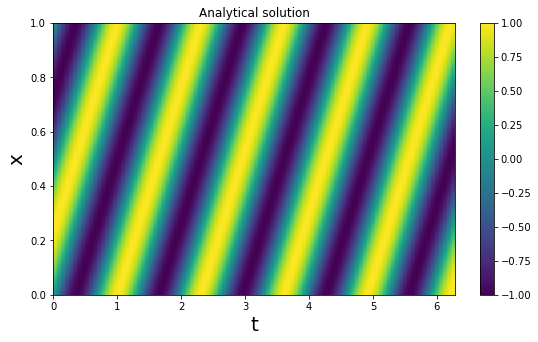

In [2]:
def plot_grid(u, t_grid, x_grid, title):
    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot()

    img_plot = ax.imshow(jnp.rot90(u), aspect='auto', extent=[t_grid.min(), t_grid.max(), x_grid.min(), x_grid.max()])
    color_bar = fig.colorbar(img_plot)

    ax.set_title(title)
    ax.set_xlabel("t", size=20)
    ax.set_ylabel("x", size=20)

u_analytic, x_grid, t_grid, _, _ = analytical_solution(beta=30)

# Plot solution
plot_grid(u_analytic, x_grid, t_grid, "Analytical solution")

In [3]:
def create_training_data(beta=1):
    u, x_grid, t_grid, x_values, t_values = analytical_solution(beta=beta)

    # Create training data for initial conditions 
    x_grid_initial = jnp.vstack([x_grid[0, :], t_grid[0, :]]).T
    u_initial = u[0, :].reshape(-1, 1)

    # Create grid points for boundary conditions at x=0 and x=2*pi
    x_grid_lbc = jnp.vstack([x_grid[:, 0], t_grid[:, 0]]).T
    x_grid_ubc = jnp.vstack([x_grid[:, -1], t_grid[:, -1]]).T

    # Sample grid points for DE residual loss
    t_values_no_initial = t_values[1:]
    x_values_no_boundary = x_values[1:-1]
    x_grid_no_boundary, x_grid_no_initial = jnp.meshgrid(x_values_no_boundary, t_values_no_initial)
    x_no_initial_no_boundary = jnp.vstack([x_grid_no_boundary.flatten(), x_grid_no_initial.flatten()]).T
    idx = jax.random.choice(jax.random.PRNGKey(42), len(x_no_initial_no_boundary), (1000,), replace=False)
    x_grid_de = x_no_initial_no_boundary[idx]

    return x_grid_initial, u_initial, x_grid_lbc, x_grid_ubc, x_grid_de

# Curriculum learning with $x, t$ as input

In [4]:
import haiku as hk
import optax

def mlp_fn(x: jnp.array) -> jnp.array:
    mlp = hk.Sequential([
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(1)
    ])

    return mlp(x)

# Initialize nn params and optimizer
net = hk.without_apply_rng(hk.transform(mlp_fn))
opt = optax.adam(5e-4)

# Net takes two inputs: x, t
params_xt = net.init(jax.random.PRNGKey(42), jnp.array([[0., 0.]]))
opt_state = opt.init(params_xt)


def loss_fn(params: hk.Params, x_data: jnp.array, y_data:jnp.array, x_grid_lbc: jnp.array, x_grid_ubc: jnp.array, x_grid_de: jnp.array, beta: float) -> float:
    # Calculate initial conditions loss
    y_pred = net.apply(params, x_data)
    loss_data = jnp.sum((y_data - y_pred)**2)

    # Calculate partial derivatives
    u = lambda x: net.apply(params, x)[0]
    du = jax.vmap(jax.grad(u))(x_grid_de)

    # Calculate DE residual loss
    loss_de = jnp.sum((du[:, 1] + beta * du[:, 0])**2)

    # Calculate BC loss 
    loss_bc = jnp.sum((net.apply(params, x_grid_lbc) - net.apply(params, x_grid_ubc))**2)

    loss = loss_data + loss_de + loss_bc
    return loss

@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, x_data: jnp.array, y_data:jnp.array, x_grid_lbc: jnp.array, x_grid_ubc: jnp.array, x_grid_de: jnp.array, beta: float):
    loss, grads = jax.value_and_grad(loss_fn)(params, x_data, y_data, x_grid_lbc, x_grid_ubc, x_grid_de, beta)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss


training_betas = jnp.linspace(1, 30, 15)
x_grid_initial, u_initial, x_grid_lbc, x_grid_ubc, x_grid_de = create_training_data()

for beta in training_betas:
    print(f"Train on beta: {beta}")

    # Train for 10000 iterations per beta
    for i in range(10000):
        params_xt, opt_state, loss = update(params_xt, opt_state, x_grid_initial, u_initial, x_grid_lbc, x_grid_ubc, x_grid_de, beta)

        if (i+1) % 1000 == 0:
            print(f"Iteration {i+1}, loss: {loss}")

Train on beta: 1.0
Iteration 1000, loss: 0.8334054350852966
Iteration 2000, loss: 0.15662850439548492
Iteration 3000, loss: 0.07357534021139145
Iteration 4000, loss: 0.04720987379550934
Iteration 5000, loss: 0.0266301017254591
Iteration 6000, loss: 0.019497336819767952
Iteration 7000, loss: 0.015449663624167442
Iteration 8000, loss: 0.024600567296147346
Iteration 9000, loss: 0.00798165611922741
Iteration 10000, loss: 0.0064692324958741665
Train on beta: 3.0714287757873535
Iteration 1000, loss: 4.606609344482422
Iteration 2000, loss: 3.2561893463134766
Iteration 3000, loss: 0.6233454942703247
Iteration 4000, loss: 0.08279815316200256
Iteration 5000, loss: 0.02533896639943123
Iteration 6000, loss: 0.01289338804781437
Iteration 7000, loss: 0.007454304490238428
Iteration 8000, loss: 0.004608865827322006
Iteration 9000, loss: 0.004485286772251129
Iteration 10000, loss: 0.004322705790400505
Train on beta: 5.142857551574707
Iteration 1000, loss: 0.6288438439369202
Iteration 2000, loss: 0.2295

## Predicted solution for $x, t$ input

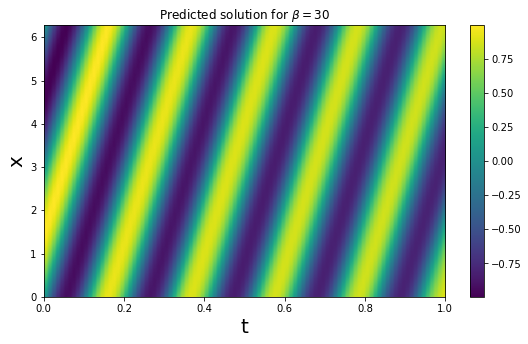

In [ ]:
whole_grid = jnp.vstack([x_grid.flatten(), t_grid.flatten()]).T

grid_preds = net.apply(params_xt, whole_grid).reshape(100, 256)

plot_grid(grid_preds, t_grid, x_grid, r"Predicted solution for $\beta = 30$")

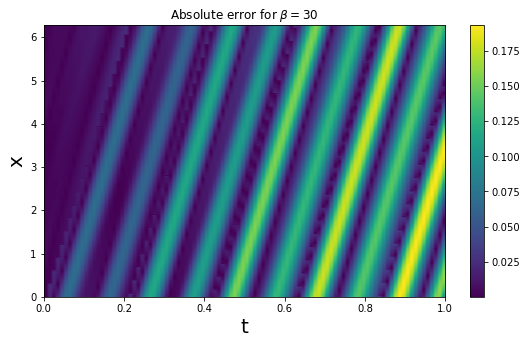

In [ ]:
u, x_grid, t_grid, x_values, t_values = analytical_solution(beta=beta)

abs_error = jnp.abs(grid_preds - u)

plot_grid(abs_error, t_grid, x_grid, r"Absolute error for $\beta = 30$")

# Curriculum learning with $x, t, \beta$ as input

In [7]:
# Initialize nn params and optimizer
net = hk.without_apply_rng(hk.transform(mlp_fn))
opt = optax.adam(5e-4)

params_xtb = net.init(jax.random.PRNGKey(42), jnp.array([[0., 0., 0.]]))
opt_state = opt.init(params_xtb)

training_betas = jnp.linspace(1, 30, 15)
x_grid_initial, u_initial, x_grid_lbc, x_grid_ubc, x_grid_de = create_training_data()

for beta in training_betas:
    print(f"Train on beta: {beta}")

    # Concat beta to inputs
    x_grid_initial_b = jnp.hstack([x_grid_initial, jnp.full((len(x_grid_initial), 1), beta)])
    x_grid_lbc_b = jnp.hstack([x_grid_lbc, jnp.full((len(x_grid_lbc), 1), beta)])
    x_grid_ubc_b = jnp.hstack([x_grid_ubc, jnp.full((len(x_grid_ubc), 1), beta)])
    x_grid_de_b = jnp.hstack([x_grid_de, jnp.full((len(x_grid_de), 1), beta)])
    
    # Train for 10000 iterations per beta
    for i in range(10000):
        params_xtb, opt_state, loss = update(params_xtb, opt_state, x_grid_initial_b, u_initial, x_grid_lbc_b, x_grid_ubc_b, x_grid_de_b, beta)

        if (i+1) % 1000 == 0:
            print(f"Iteration {i+1}, loss: {loss}")

Train on beta: 1.0
Iteration 1000, loss: 0.2416701316833496
Iteration 2000, loss: 0.04523986205458641
Iteration 3000, loss: 0.015858257189393044
Iteration 4000, loss: 0.10632622241973877
Iteration 5000, loss: 0.008027439936995506
Iteration 6000, loss: 0.005506046582013369
Iteration 7000, loss: 0.005987722426652908
Iteration 8000, loss: 0.004314351361244917
Iteration 9000, loss: 0.0036201642360538244
Iteration 10000, loss: 0.011351870372891426
Train on beta: 3.0714287757873535
Iteration 1000, loss: 1.9480823278427124
Iteration 2000, loss: 0.1193542405962944
Iteration 3000, loss: 0.3478420078754425
Iteration 4000, loss: 0.040208615362644196
Iteration 5000, loss: 0.030778195708990097
Iteration 6000, loss: 0.02444898709654808
Iteration 7000, loss: 0.018474841490387917
Iteration 8000, loss: 0.027874551713466644
Iteration 9000, loss: 0.012758092023432255
Iteration 10000, loss: 0.13793334364891052
Train on beta: 5.142857551574707
Iteration 1000, loss: 0.26245740056037903
Iteration 2000, loss:

## Predicted solution for $x, t, \beta$ input

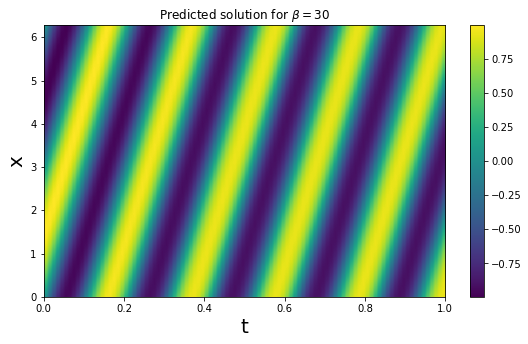

In [8]:
beta = 30.

whole_grid = jnp.vstack([x_grid.flatten(), t_grid.flatten()]).T
whole_grid_b = jnp.hstack([whole_grid, jnp.full((len(whole_grid), 1), beta)])

grid_preds = net.apply(params_xtb, whole_grid_b).reshape(100, 256)
plot_grid(grid_preds, t_grid, x_grid, r"Predicted solution for $\beta = 30$")

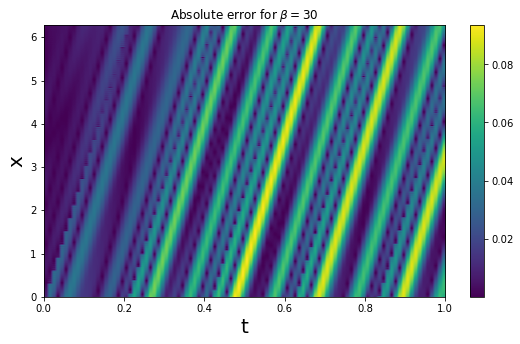

In [ ]:
u, x_grid, t_grid, x_values, t_values = analytical_solution(beta=beta)

abs_error = jnp.abs(grid_preds - u)

plot_grid(abs_error, t_grid, x_grid, r"Absolute error for $\beta = 30$")

# WIP: Train network parametrized on $\beta$ 

This does not work yet. The network seems to learn an "averaged" solution over all betas.

In [10]:
import copy

params_beta = copy.deepcopy(params_xtb)

key = jax.random.PRNGKey(42)

opt_state = opt.init(params_beta)
losses = []
# Train for 10000 iterations per beta
for i in range(10000):
    key, subkey = jax.random.split(key)
    beta = jax.random.uniform(subkey, (1,))[0] * 30

    x_grid_initial_b = jnp.hstack([x_grid_initial, jnp.full((len(x_grid_initial), 1), beta)])
    x_grid_lbc_b = jnp.hstack([x_grid_lbc, jnp.full((len(x_grid_lbc), 1), beta)])
    x_grid_ubc_b = jnp.hstack([x_grid_ubc, jnp.full((len(x_grid_ubc), 1), beta)])
    x_grid_de_b = jnp.hstack([x_grid_de, jnp.full((len(x_grid_de), 1), beta)])

    params_beta, opt_state, loss = update(params_beta, opt_state, x_grid_initial_b, u_initial, x_grid_lbc_b, x_grid_ubc_b, x_grid_de_b, beta)
    losses.append(loss)

    if (i+1) % 1000 == 0:
        print(f"Iteration {i+1}, loss: {jnp.mean(jnp.array(losses))}")

Iteration 1000, loss: 13026.7529296875
Iteration 2000, loss: 6878.8623046875
Iteration 3000, loss: 4707.591796875
Iteration 4000, loss: 3583.691650390625
Iteration 5000, loss: 2925.3427734375
Iteration 6000, loss: 2463.87158203125
Iteration 7000, loss: 2140.373779296875
Iteration 8000, loss: 1890.1390380859375
Iteration 9000, loss: 1693.9364013671875
Iteration 10000, loss: 1536.3404541015625


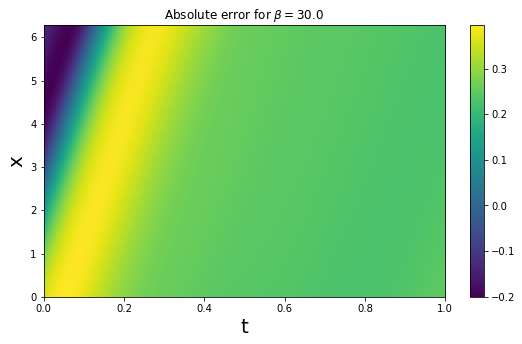

In [13]:
beta = 30.

whole_grid = jnp.vstack([x_grid.flatten(), t_grid.flatten()]).T
whole_grid_b = jnp.hstack([whole_grid, jnp.full((len(whole_grid), 1), beta)])

grid_preds = net.apply(params_beta, whole_grid_b).reshape(100, 256)
plot_grid(grid_preds, t_grid, x_grid, rf"Absolute error for $\beta = {beta}$")